In [28]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from tqdm import tqdm
import json
def get_sentiment_scores(text):
    MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    def preprocess(text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)

    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    results = []
    for i in range(scores.shape[0]):
        label = config.id2label[ranking[i]]
        score = scores[ranking[i]]
        results.append((label, np.round(float(score), 4)))
    sentiment_dict = {label: score for label, score in results}
    return sentiment_dict

def process_json_file(input_file, output_file):
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    for item in tqdm(data):
        post = item['Post']
        transferred_post = item['Transferred_Post_llama2:70B']
        post_sentiment_scores = get_sentiment_scores(post)
        transferred_post_sentiment_scores = get_sentiment_scores(transferred_post)
        item['Post_Postive'] = post_sentiment_scores['positive']
        item['Post_Negative'] = post_sentiment_scores['negative']
        item['Post_Neutral'] = post_sentiment_scores['neutral']
        item['Transferred_Post_Postive'] = transferred_post_sentiment_scores['positive']
        item['Transferred_Post_Negative'] = transferred_post_sentiment_scores['negative']
        item['Transferred_Post_Neutral'] = transferred_post_sentiment_scores['neutral']

    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)
#GAS
input_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/transfered/20_GAS2SPAS_GAS2SPAS.json"
output_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/sentiment/GAS2SPAS_sentiment.json"

#IAS
# input_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/transfered/20_IAS2EAS_IAS2EAS.json"
# output_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/sentiment/IAS2EAS_sentiment.json"
# process_json_file(input_file, output_file)

#SAS
# input_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/transfered/20_SAS2UAS_SAS2UAS.json"
# output_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/sentiment/SAS2UAS_sentiment.json"
process_json_file(input_file, output_file)

  0%|          | 0/20 [00:00<?, ?it/s]Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are i

Average Scores:
Post Positive: 0.035960000000000006
Post Negative: 0.88932
Post Neutral: 0.07472000000000001
Transferred Post Positive: 0.302065
Transferred Post Negative: 0.330275
Transferred Post Neutral: 0.36767500000000003


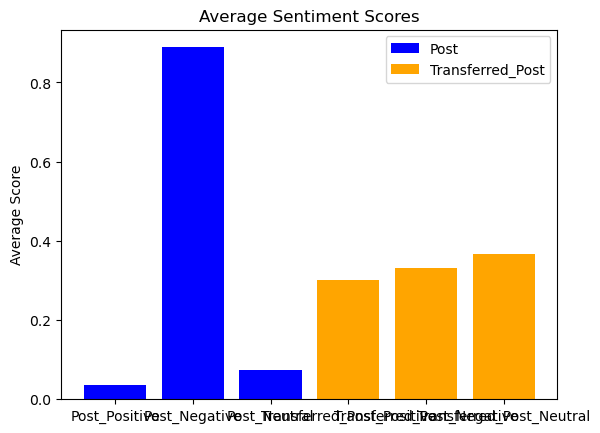

In [36]:
import json
import numpy as np
import matplotlib.pyplot as plt

def calculate_average(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    post_positive = []
    post_negative = []
    post_neutral = []
    transferred_post_positive = []
    transferred_post_negative = []
    transferred_post_neutral = []

    for item in data:
        post_positive.append(item['Post_Postive'])
        post_negative.append(item['Post_Negative'])
        post_neutral.append(item['Post_Neutral'])
        transferred_post_positive.append(item['Transferred_Post_Postive'])
        transferred_post_negative.append(item['Transferred_Post_Negative'])
        transferred_post_neutral.append(item['Transferred_Post_Neutral'])

    post_positive_avg = np.mean(post_positive)
    post_negative_avg = np.mean(post_negative)
    post_neutral_avg = np.mean(post_neutral)
    transferred_post_positive_avg = np.mean(transferred_post_positive)
    transferred_post_negative_avg = np.mean(transferred_post_negative)
    transferred_post_neutral_avg = np.mean(transferred_post_neutral)

    return (post_positive_avg, post_negative_avg, post_neutral_avg, transferred_post_positive_avg, transferred_post_negative_avg, transferred_post_neutral_avg)

def plot_bar_chart(averages):
    labels = ['Post_Positive', 'Post_Negative', 'Post_Neutral', 'Transferred_Post_Positive', 'Transferred_Post_Negative', 'Transferred_Post_Neutral']
    values = averages

    fig, ax = plt.subplots()
    ax.bar(labels[:3], values[:3], color='blue', label='Post')
    ax.bar(labels[3:], values[3:], color='orange', label='Transferred_Post')
    ax.set_ylabel('Average Score')
    ax.set_title('Average Sentiment Scores')
    ax.legend()
    plt.show()

json_file = "/home/qiang/projects/Digital_mental_health/Tasks/Style_transfer_task/methods/llama2:70B/sentiment/GAS2SPAS_sentiment.json"
averages = calculate_average(json_file)
print("Average Scores:")
print("Post Positive:", averages[0])
print("Post Negative:", averages[1])
print("Post Neutral:", averages[2])
print("Transferred Post Positive:", averages[3])
print("Transferred Post Negative:", averages[4])
print("Transferred Post Neutral:", averages[5])

plot_bar_chart(averages)